<a href="https://colab.research.google.com/github/jackiekuen2/notes-handson-ml-tf/blob/master/ch5_SVMClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('xtick', labelsize=12)

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b =0
    #==> x1 = -w0/w1 * x0  -b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1] # x1

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# 1. Linear SVM Classification

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [0]:
iris = datasets.load_iris()

In [0]:
X = iris.data[:, (2, 3)] # only use two features: petal length & petal width
y = (iris.target == 2).astype(np.float64) # Class 2 Iris-Virginicab

Use small C value (C=1), and hinge loss function

In [0]:
scaler = StandardScaler()
svm_clf = LinearSVC(C=1, loss='hinge', random_state=42)

scaled_svm_clf = Pipeline([
                    ('scaler', scaler),
                    ('linear_svc', svm_clf)
])

scaled_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [0]:
# Convert to unscaled parameters
b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])
w = svm_clf.coef_[0] / scaler.scale_
svm_clf.intercept_ = np.array([b])
svm_clf.coef_ = np.array([w])

# Find support vectors
t = y * 2 - 1
support_vectors_idx = (t * (X.dot(w) + b) < 1).ravel()
svm_clf.support_vectors_ = X[support_vectors_idx]

[4, 6, 0.8, 2.8]

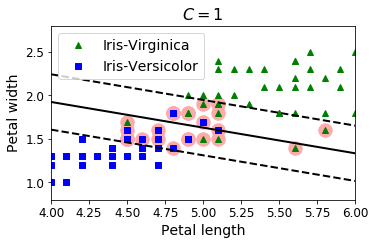

In [0]:
plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^', label='Iris-Virginica')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs', label='Iris-Versicolor')
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

# 2. Non-linear SVM Classification

## 2A. Adding Polynomial Features

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_moons

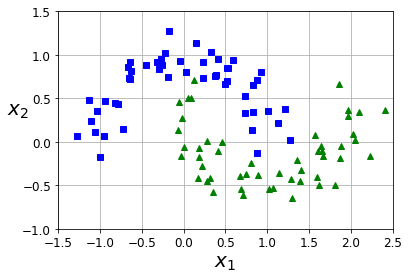

In [0]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [0]:
polynomial_svm_clf = Pipeline([
                               ('poly_features', PolynomialFeatures(degree=3)),
                               ('scaler', StandardScaler()),
                               ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

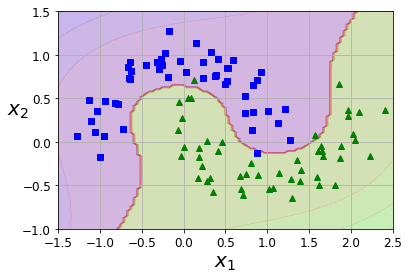

In [0]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## 2B. Polynomial Kernel

In [0]:
from sklearn.svm import SVC

In [0]:
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5)),
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
poly100_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5)),
])

poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

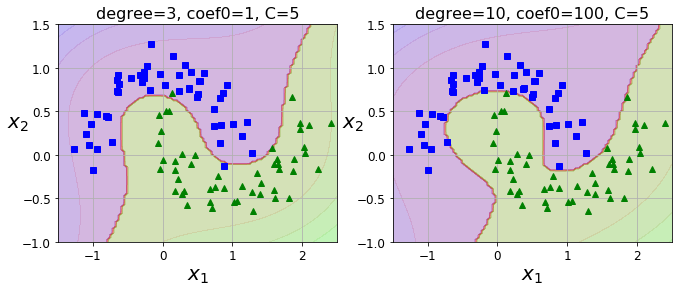

In [0]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(clf=poly_kernel_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r'degree=3, coef0=1, C=5', fontsize=16)

plt.subplot(122)
plot_predictions(clf=poly100_kernel_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r'degree=10, coef0=100, C=5', fontsize=16)

plt.show()

## 2C. Gaussian RBF Kernel

In [0]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ('scaler', StandardScaler()),
            ('svm_clf', SVC(kernel='rbf', gamma=gamma, C=C))
    ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

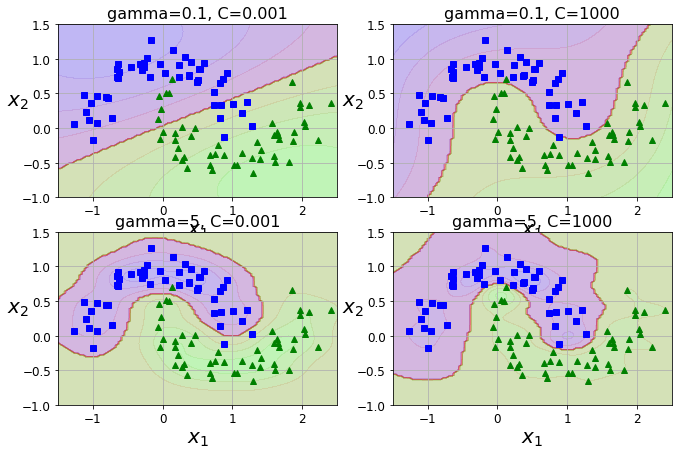

In [0]:
plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(clf=svm_clf, axes=[-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r'gamma={}, C={}'.format(gamma, C), fontsize=16)

plt.show()